# Phonons

In this example coherent acoustic phonon dynamics are calculated according to the results of the `heat` simulations.

## Setup

Do all necessary imports and settings.

In [1]:
import udkm1Dsim as ud
u = ud.u  # import the pint unit registry from udkm1Dsim
import scipy.constants as constants
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
u.setup_matplotlib()  # use matplotlib with pint units

## Structure

Refer to the [structure-example](structure.ipynb) for more details.

In [2]:
O = ud.Atom('O')
Ti = ud.Atom('Ti')
Sr = ud.Atom('Sr')
Ru = ud.Atom('Ru')
Pb = ud.Atom('Pb')
Zr = ud.Atom('Zr')

In [3]:
# c-axis lattice constants of the two layers
c_STO_sub = 3.905*u.angstrom
c_SRO = 3.94897*u.angstrom
# sound velocities [nm/ps] of the two layers
sv_SRO = 6.312*u.nm/u.ps
sv_STO = 7.800*u.nm/u.ps

# SRO layer
prop_SRO = {}
prop_SRO['a_axis'] = c_STO_sub  # aAxis
prop_SRO['b_axis'] = c_STO_sub  # bAxis
prop_SRO['deb_Wal_Fac'] = 0  # Debye-Waller factor
prop_SRO['sound_vel'] = sv_SRO  # sound velocity
prop_SRO['opt_ref_index'] = 2.44+4.32j
prop_SRO['therm_cond'] = 5.72*u.W/(u.m *u.K)  # heat conductivity
prop_SRO['lin_therm_exp'] = 1.03e-5  # linear thermal expansion
prop_SRO['heat_capacity'] = '455.2 + 0.112*T - 2.1935e6/T**2'  # heat capacity [J/kg K]

SRO = ud.UnitCell('SRO', 'Strontium Ruthenate', c_SRO, **prop_SRO)
SRO.add_atom(O, 0)
SRO.add_atom(Sr, 0)
SRO.add_atom(O, 0.5)
SRO.add_atom(O, 0.5)
SRO.add_atom(Ru, 0.5)

# STO substrate
prop_STO_sub = {}
prop_STO_sub['a_axis'] = c_STO_sub  # aAxis
prop_STO_sub['b_axis'] = c_STO_sub  # bAxis
prop_STO_sub['deb_Wal_Fac'] = 0  # Debye-Waller factor
prop_STO_sub['sound_vel'] = sv_STO  # sound velocity
prop_STO_sub['opt_ref_index'] = 2.1+0j
prop_STO_sub['therm_cond'] = 12*u.W/(u.m *u.K)  # heat conductivity
prop_STO_sub['lin_therm_exp'] = 1e-5  # linear thermal expansion
prop_STO_sub['heat_capacity'] = '733.73 + 0.0248*T - 6.531e6/T**2'  # heat capacity [J/kg K]

STO_sub = ud.UnitCell('STOsub', 'Strontium Titanate Substrate', c_STO_sub, **prop_STO_sub)
STO_sub.add_atom(O, 0)
STO_sub.add_atom(Sr, 0)
STO_sub.add_atom(O, 0.5)
STO_sub.add_atom(O, 0.5)
STO_sub.add_atom(Ti, 0.5)

In [4]:
S = ud.Structure('Single Layer')
S.add_sub_structure(SRO, 100)  # add 100 layers of SRO to sample
S.add_sub_structure(STO_sub, 2000)  # add 1000 layers of STO substrate

## Heat

Refer to the [heat-example](heat.ipynb) for more details.

In [5]:
h = ud.Heat(S, True)

h.save_data = False
h.disp_messages = True

h.excitation = {'fluence': [5]*u.mJ/u.cm**2,
                'delay_pump':  [0]*u.ps,
                'pulse_width':  [0]*u.ps,
                'multilayer_absorption': True,
                'wavelength': 800*u.nm,
                'theta': 45*u.deg}

# temporal and spatial grid
delays = np.r_[-10:90:0.1]*u.ps
_, _, distances = S.get_distances_of_layers()

In [6]:
temp_map, delta_temp_map = h.get_temp_map(delays, 300*u.K)

Surface incidence fluence scaled by factor 0.7071 due to incidence angle theta=45.00 deg
Absorption profile is calculated by multilayer formalism.
Total reflectivity of 56.1 % and transmission of 5.7 %.
Elapsed time for _temperature_after_delta_excitation_: 0.030068 s
Elapsed time for _temp_map_: 0.161679 s


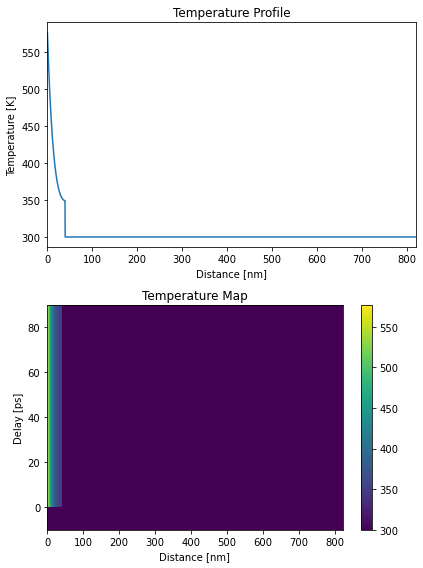

In [7]:
plt.figure(figsize=[6, 8])
plt.subplot(2, 1, 1)
plt.plot(distances.to('nm').magnitude, temp_map[101, :])
plt.xlim([0, distances.to('nm').magnitude[-1]])
plt.xlabel('Distance [nm]')
plt.ylabel('Temperature [K]')
plt.title('Temperature Profile')

plt.subplot(2, 1, 2)
plt.pcolormesh(distances.to('nm').magnitude, delays.to('ps').magnitude, temp_map, shading='auto')
plt.colorbar()
plt.xlabel('Distance [nm]')
plt.ylabel('Delay [ps]')
plt.title('Temperature Map')

plt.tight_layout()
plt.show()

## Analytical Phonons

The `PhononAna` class requires a `Structure` object and a boolean `force_recalc` in order overwrite previous simulation results.

These results are saved in the `cache_dir` when `save_data` is enabled.
Printing simulation messages can be en-/disabled using `disp_messages` and progress bars can using the boolean switch `progress_bar`.

In [8]:
pana = ud.PhononAna(S, True)
pana.save_data = False
pana.disp_messages = True

In [9]:
strain_map, A, B = pana.get_strain_map(delays, temp_map, delta_temp_map)

Calculating linear thermal expansion ...
Calculating _eigen_values_ ...
Elapsed time for _eigen_values_: 4.187524 s
Calculating _strain_map_ ...


Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Elapsed time for _strain_map_: 31.936874 s


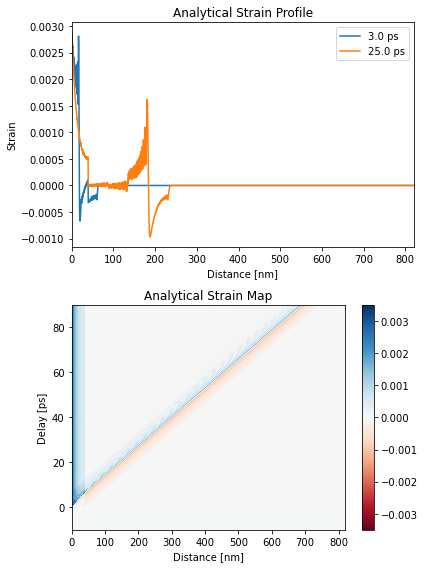

In [10]:
plt.figure(figsize=[6, 8])
plt.subplot(2, 1, 1)
plt.plot(distances.to('nm').magnitude, strain_map[130, :],
         label=np.round(delays[130]))
plt.plot(distances.to('nm').magnitude, strain_map[350, :],
         label=np.round(delays[350]))
plt.xlim([0, distances.to('nm').magnitude[-1]])
plt.xlabel('Distance [nm]')
plt.ylabel('Strain')
plt.legend()
plt.title('Analytical Strain Profile')

plt.subplot(2, 1, 2)
plt.pcolormesh(distances.to('nm').magnitude, delays.to('ps').magnitude,
               strain_map, cmap='RdBu',
               vmin=-np.max(strain_map), vmax=np.max(strain_map), shading='auto')
plt.colorbar()
plt.xlabel('Distance [nm]')
plt.ylabel('Delay [ps]')
plt.title('Analytical Strain Map')

plt.tight_layout()
plt.show()

### Energy Spectrum

The analytical phonon model easily allows for calculating the energy per eigenmode of the coherent acoustic phonon spectrum for every delay of the simulation. 

In [11]:
omega, E = pana.get_energy_per_eigenmode(A, B)

Calculating _eigen_values_ ...
Elapsed time for _eigen_values_: 4.513158 s


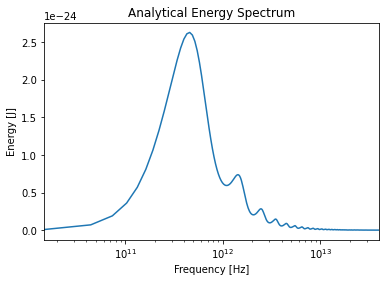

In [12]:
plt.figure()
plt.plot(omega, E[-1, :])
plt.xlim(omega[0], omega[-1])
plt.xscale('log')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Energy [J]')
plt.title('Analytical Energy Spectrum')
plt.show()

## Numerical Phonons

The `PhononNum` class requires a `Structure` object and a boolean `force_recalc` in order overwrite previous simulation results.

These results are saved in the `cache_dir` when `save_data` is enabled.
Printing simulation messages can be en-/disabled using `disp_messages` and progress bars can using the boolean switch `progress_bar`.

In [13]:
pnum = ud.PhononNum(S, True)
pnum.save_data = False
pnum.disp_messages = True

The actual calculation is done in one line:

In [14]:
strain_map = pnum.get_strain_map(delays, temp_map, delta_temp_map)

Calculating linear thermal expansion ...
Calculating coherent dynamics with ODE solver ...


0it [00:00, ?it/s]

Elapsed time for _strain_map_: 1.630938 s


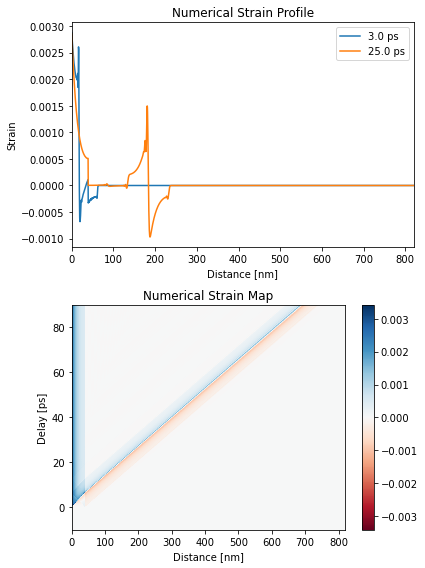

In [15]:
plt.figure(figsize=[6, 8])
plt.subplot(2, 1, 1)
plt.plot(distances.to('nm').magnitude, strain_map[130, :],
         label=np.round(delays[130]))
plt.plot(distances.to('nm').magnitude, strain_map[350, :],
         label=np.round(delays[350]))
plt.xlim([0, distances.to('nm').magnitude[-1]])
plt.xlabel('Distance [nm]')
plt.ylabel('Strain')
plt.legend()
plt.title('Numerical Strain Profile')

plt.subplot(2, 1, 2)
plt.pcolormesh(distances.to('nm').magnitude, delays.to('ps').magnitude,
               strain_map, cmap='RdBu',
               vmin=-np.max(strain_map), vmax=np.max(strain_map), shading='auto')
plt.colorbar()
plt.xlabel('Distance [nm]')
plt.ylabel('Delay [ps]')
plt.title('Numerical Strain Map')

plt.tight_layout()
plt.show()

## Anharmonic Phonon Propagation

The numerical phonon dynamic calculations also allow for phonon damping and non-linear phonon propagation.
This can be achieved by setting the `phonon_damping` property and using the `set_ho_spring_constants()` method of the according layers.

In [16]:
STO_sub.phonon_damping = -1e10*u.kg/u.s
STO_sub.set_ho_spring_constants([-7e11])

Recalculate the coherent phonon dynamics:

In [17]:
strain_map = pnum.get_strain_map(delays, temp_map, delta_temp_map)

Calculating linear thermal expansion ...
Calculating coherent dynamics with ODE solver ...


0it [00:00, ?it/s]

Elapsed time for _strain_map_: 1.979508 s


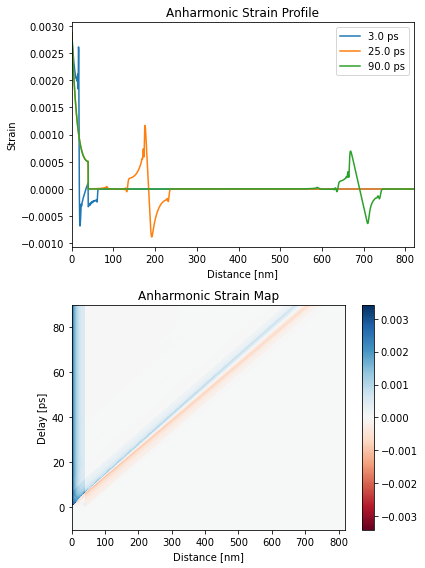

In [18]:
plt.figure(figsize=[6, 8])
plt.subplot(2, 1, 1)
plt.plot(distances.to('nm').magnitude, strain_map[130, :],
         label=np.round(delays[130]))
plt.plot(distances.to('nm').magnitude, strain_map[350, :],
         label=np.round(delays[350]))
plt.plot(distances.to('nm').magnitude, strain_map[-1, :],
         label=np.round(delays[-1]))
plt.xlim([0, distances.to('nm').magnitude[-1]])
plt.xlabel('Distance [nm]')
plt.ylabel('Strain')
plt.legend()
plt.title('Anharmonic Strain Profile')

plt.subplot(2, 1, 2)
plt.pcolormesh(distances.to('nm').magnitude, delays.to('ps').magnitude,
               strain_map, cmap='RdBu',
               vmin=-np.max(strain_map), vmax=np.max(strain_map), shading='auto')
plt.colorbar()
plt.xlabel('Distance [nm]')
plt.ylabel('Delay [ps]')
plt.title('Anharmonic Strain Map')

plt.tight_layout()
plt.show()